# Ensemble Learning through Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


In [1]:
!git clone https://github.com/tlpss/ML-Project2.git

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
sys.path.append(os.path.abspath(os.path.join('./ML-Project2')))

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

Cloning into 'ML-Project2'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 141 (delta 64), reused 104 (delta 37), pack-reused 0
Receiving objects: 100% (141/141), 793.87 KiB | 1.06 MiB/s, done.
Resolving deltas: 100% (64/64), done.


## Parameter Configuration

In [2]:
np.random.seed(2020)

In [3]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [4]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [5]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [6]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [7]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07935344411249907

In [8]:
X_test.shape

(50000, 1, 2)

## Create Custom Models
(to have more control of splitting etc)

In [9]:
from aggregating.models import SimpleBagger
s = SimpleBagger(11,0.5,None)
s.get_params()

{'M': 11, 'predictor': None, 'train_size_alpha': 0.5}

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [14]:
#reference:
from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

hyperparams= {'M':1, 'train_size_alpha':1.0}
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],3,N_test,MaxCallStochasticModel)
print(reference_error)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 139975247869824
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.12082437013741118
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.143336782069863
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.17212503138499305
{'M': 1, 'train_size_alpha': 1.0} -> [0.12082437013741118, 0.143336782069863, 0.17212503138499305]
[0.12082437013741118, 0.143336782069863, 0.17212503138499305]


In [23]:
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

0.14542872786408909


In [16]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

# GRIDSEARCH PARAMS
model = SimpleBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [5,7,9,11,13]
alpha_grid = [0.01,0.05,0.1,0.3,0.5]
results = []
print(cpu_count())
### ACTUAL GRIDSEARCH
pool = ThreadPool(2) #avoid allocation issues
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



2
 {'M': 5, 'train_size_alpha': 0.01} -> thread id = 139974533728000
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.05} -> thread id = 139974525335296
fit
(5000, 2)
predict
(50000, 2)
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.01} , 0 -> 0.2890129423321955
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.01} , 1 -> 0.2838776048049625
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.01} , 2 -> 0.3073243572374536
{'M': 5, 'train_size_alpha': 0.01} -> [0.2890129423321955, 0.2838776048049625, 0.3073243572374536]
 {'M': 5, 'train_size_alpha': 0.1} -> thread id = 139974533728000logger {'M': 5, 'train_size_alpha': 0.01}, -> [0.2890129423321955, 0.2838776048049625, 0.3073243572374536]

fit
(5000, 2)
{'M': 5, 'train_size_alpha': 0.05} , 0 -> 0.19802184713242416
predict
(50000, 2)
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.05} , 1 -> 0.19031140578587086
predict
(50000, 2)
{'M': 5, 'train_size_alpha': 0.05} , 2 -> 0.19036677146001882
{'M': 5, 'train_size_alpha': 0.05} -> [0.1980218

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.5} , 0 -> 0.17532315432647594
predict
(50000, 2)
{'M': 11, 'train_size_alpha': 0.1} , 0 -> 0.24561055332309117
predict
(50000, 2)
{'M': 11, 'train_size_alpha': 0.1} , 1 -> 0.24098015398727834
predict
(50000, 2)
{'M': 11, 'train_size_alpha': 0.1} , 2 -> 0.24972432718875792
{'M': 11, 'train_size_alpha': 0.1} -> [0.24561055332309117, 0.24098015398727834, 0.24972432718875792]
 {'M': 11, 'train_size_alpha': 0.3} -> thread id = 139974525335296logger {'M': 11, 'train_size_alpha': 0.1}, -> [0.24561055332309117, 0.24098015398727834, 0.24972432718875792]

fit
(5000, 2)
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.5} , 1 -> 0.18696460960183287
predict
(50000, 2)
{'M': 11, 'train_size_alpha': 0.3} , 0 -> 0.10712613766630205
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.5} , 2 -> 0.18029456489687473
{'M': 9, 'train_size_alpha': 0.5} -> [0.17532315432647594, 0.18696460960183287, 0.18029456489687473]
 {'M': 11, 'train_size_alpha': 0.5} -> thr

In [17]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[5, 0.01, [0.2890129423321955, 0.2838776048049625, 0.3073243572374536]]
[5, 0.05, [0.19802184713242416, 0.19031140578587086, 0.19036677146001882]]
[5, 0.1, [0.28322856265916463, 0.29700226836606153, 0.32301660765043316]]
[5, 0.3, [0.11643802516311454, 0.13391743601401662, 0.1490345516218128]]
[7, 0.01, [0.2800065252490135, 0.2796209598047984, 0.2833029583186165]]
[7, 0.05, [0.23405782249844362, 0.21556029782964695, 0.2043707660251198]]
[7, 0.1, [0.20085903131031319, 0.1941008246990516, 0.16356729365214592]]
[5, 0.5, [0.18479491389451103, 0.12651148887628724, 0.13281616406360008]]
[7, 0.3, [0.1258579613029221, 0.13839454024634978, 0.09782251080932804]]
[9, 0.01, [0.29850238830255477, 0.28243284915948424, 0.27440717659744834]]
[9, 0.05, [0.1897003508311039, 0.1883224889252994, 0.19616428855061974]]
[9, 0.1, [0.24843985373119112, 0.2667202732449569, 0.27689980511065043]]
[7, 0.5, [0.12731370583490648, 0.14800251534853628, 0.16646752466555675]]
[9, 0.3, [0.15037722997788522, 0.135495689615

In [18]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(5, 5)

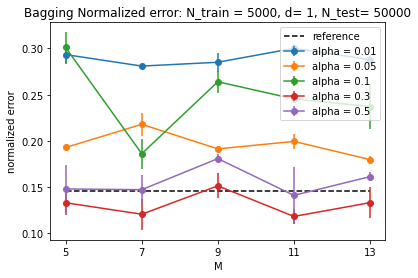

In [29]:
plt.hlines(reference_error_mean,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.show()

## Store results

In [ ]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [ ]:
import json
import datetime
with open(f'bagging_w_replacement_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)